# Bayesian Outlier Control Experiment

**Goal**
- Determine if the model provides information from background datasets that allows it to "fill in" for instances where the sample has no matching normal tissue or few samples.

**Inputs**
- TCGA expression data. Normalized, filtered, and centered
- Druggable genes list - What we'll add to our gene lists to check later

**Outputs**

Each run for an n-of-1 will output directories which contain the following
- Image of weights by tissue
- Vector of PPP for training genes
- model.pkl

Diretory structure
- Control-Runs
    - <N-of-1 Sample ID> 
        - MatchedNormal
        - MN_[x]
            - where x is 1-10, 15, 20
        - OtherNormals 
            - Normal set - matched normal
        - Other_MN10
        - Other_MN5
        - AllNormals

**Methods**
- Pick n-of-1
    - Pick a matching TCGA Normal (can do exact same with GTEx tissue)
    - Perform comparisons
    - For each comparison save:
        - Image of weights (if applicable)
        - Vector of pvalues for training genes
        - Model.pkl

# Inputs

In [1]:
import os
import warnings
warnings.filterwarnings('ignore')

import rnaseq_lib3 as r
import pandas as pd
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

from pathlib import Path
from tqdm import tqdm_notebook as tqdm

In [2]:
# Read in centered data
df = pd.read_hdf('/mnt/data/expression/tcga_gtex_tpm_norm_filt_centered.hd5')
# Subset
gtex = df[df.label == 'gtex']
normal = df[df.label == 'tcga-normal']
tumor = df[df.label == 'tcga-tumor']
# Read in drug genes
drug_genes = [x.split('\t')[0] for x in open('../data/druggable-genes.tsv', 'r').readlines()]
drug_genes = [x for x in drug_genes if x in df.columns]

# Dataset

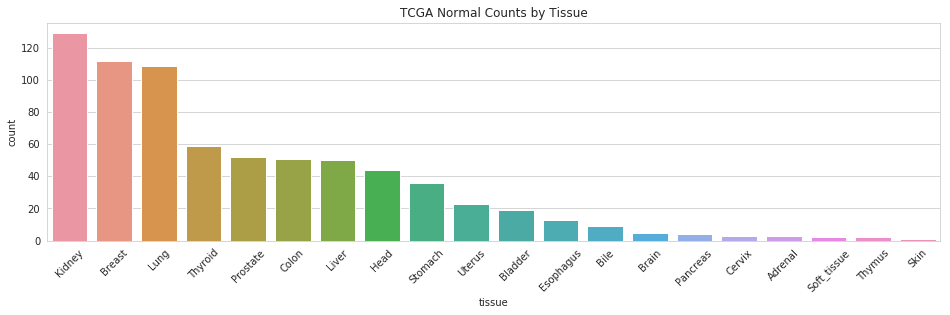

In [3]:
plt.figure(figsize=(16, 4))
plt.xticks(rotation=45)
sns.countplot(normal.tissue, order=normal.tissue.value_counts().index)
plt.title('TCGA Normal Counts by Tissue');

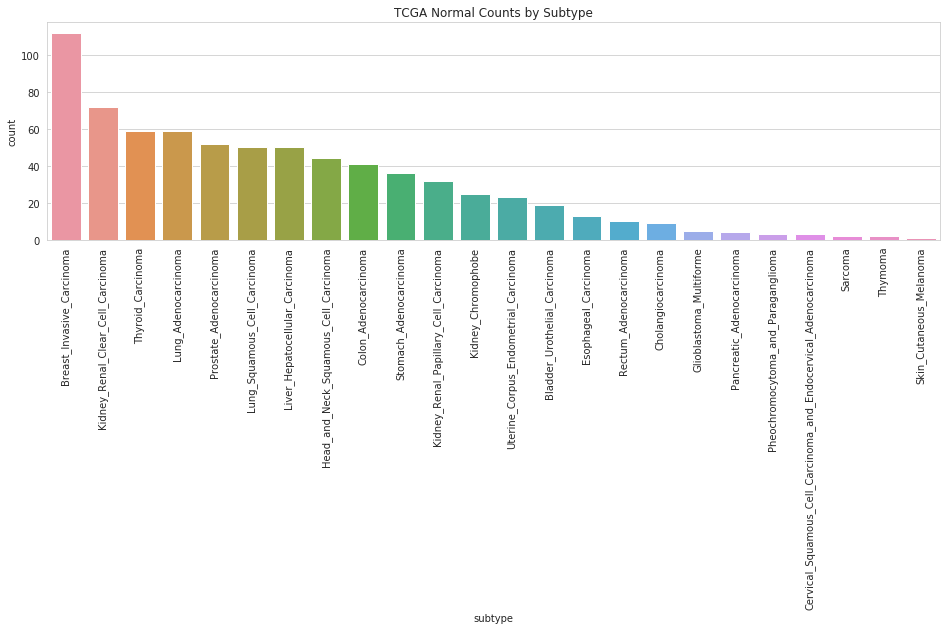

In [4]:
plt.figure(figsize=(16, 4))
plt.xticks(rotation=90)
sns.countplot(normal.subtype, order=normal.subtype.value_counts().index)
plt.title('TCGA Normal Counts by Subtype');

 # Experiment Runs

## Pick N-of-1s

Pick 10 N-of-1s from tissues that have more than 20 samples

In [5]:
tissue_counts = normal.tissue.value_counts()
candidate_tissues = tissue_counts[tissue_counts > 20].index
candidates = tumor[tumor.tissue.isin(candidate_tissues)]
candidates = tumor.loc[np.random.choice(candidates.id, 10)]

In [6]:
candidates = ['TCGA-G7-7502-01', 'TCGA-LQ-A4E4-01', 'TCGA-GM-A2D9-01', 
              'TCGA-CG-5718-01', 'TCGA-F9-A7Q0-01', 'TCGA-L6-A4EP-01',
              'TCGA-EP-A26S-01', 'TCGA-E8-A418-01', 'TCGA-60-2724-01', 
              'TCGA-CV-7250-01']
candidates = tumor.loc[candidates]

## Select Training Genes

85 Drug Genes + 50 discriminant genes = 135

In [7]:
genes = df.columns[5:]
training_genes = r.outlier.select_k_best_genes(normal, genes, 'tissue', 50)
training_genes = training_genes + drug_genes

## Perform Runs

In [8]:
def run_experiment(sample, background_df, class_col, training_genes, out_dir):
    # Create experiment dir
    run_dir = Path('Control-Runs')
    out_dir = run_dir / f'{sample.id}-{sample.tissue}' / out_dir
    os.makedirs(out_dir, exist_ok=True)

    # Run model and pickle output
    m_path = out_dir / 'model.pkl'
    if os.path.exists(m_path):
        m, t = r.outlier._load_pickle(m_path)
    else:
        m, t = r.outlier.model(sample, background_df, class_col, training_genes)
        r.outlier._pickle(m_path, model=m, trace=t)

    # Calculate and save posterior p-values
    pval_path = out_dir / 'pvals.tsv'
    if not os.path.exists(pval_path):
        ppp = r.outlier.posterior_pvalues(sample, trace=t, model=m, genes=training_genes)
        ppp.to_csv(pval_path, sep='\t')
    
    # Save image of weights by class if if n_classes > 1
    weight_path = out_dir / 'weights.pdf'
    if not os.path.exists(weight_path):
        classes = sorted(background_df[class_col].unique())
        if len(classes) > 1:
            r.outlier.plot_weights(classes, trace=t, output=weight_path)

In [ ]:
%matplotlib inline
for i, sample in candidates.iterrows():
    print(f'Sample: {sample.id}')
    
    # MatchedNormal
    print('\tRunning MatchedNormal')
    mn = normal[normal.tissue == sample.tissue]
    run_experiment(sample, mn, 'tissue', training_genes, 'MatchedNormal')
    
    # MN_X runs
    print('\tRunning MatchedNormal_x')
    for x in list(range(1, 11, 3)) + [15, 20]:
        mn_sub = mn.loc[np.random.choice(mn.id, x, replace=False)]
        run_experiment(sample, mn_sub, 'tissue', training_genes, f'MN_{x}')
    
    # OtherNormals
    print('\tRunning OtherNormals')
    on = normal[normal.tissue != sample.tissue]
    run_experiment(sample, on, 'tissue', training_genes, 'OtherNormals')
    
    # ON + MN_5
    print('\tRunning OtherNormals + 5 MatchedNormals')
    mn5 = mn.loc[np.random.choice(mn.id, 5, replace=False)]
    on_mn5 = pd.concat([on, mn5])
    run_experiment(sample, on_mn5, 'tissue', training_genes, 'OtherNormals_MN5')
    
    # ON + MN_10
    print('\tRunning OtherNormals + 10 MatchedNormals')
    mn10 = mn.loc[np.random.choice(mn.id, 10, replace=False)]
    on_mn10 = pd.concat([on, mn10])
    run_experiment(sample, on_mn10, 'tissue', training_genes, 'OtherNormals_MN10')
    
    # AllNormals
    print('\tRunning AllNormals')
    run_experiment(sample, normal, 'tissue', training_genes, 'AllNormals')

Sample: TCGA-G7-7502-01
	Running MatchedNormal
	Running MatchedNormal_x
	Running OtherNormals
	Running OtherNormals + 5 MatchedNormals
	Running OtherNormals + 10 MatchedNormals


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b, sigma_b, mu_b, a]
100%|██████████| 500/500 [04:42<00:00, 10.00it/s]  


	Running AllNormals


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b, sigma_b, mu_b, a]
100%|██████████| 500/500 [05:22<00:00,  8.81it/s]  


Sample: TCGA-LQ-A4E4-01
	Running MatchedNormal


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b, a]
100%|██████████| 500/500 [05:39<00:00,  1.47it/s]  


	Running MatchedNormal_x


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b, a]
100%|██████████| 500/500 [01:40<00:00,  9.84it/s] 
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b, a]
100%|██████████| 500/500 [05:42<00:00,  1.46it/s]  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b, a]
100%|██████████| 500/500 [06:26<00:00,  1.29it/s]  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b, a]
100%|██████████| 500/500 [06:59<00:00, 12.10it/s]  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b, a]
100%|██████████| 500/500 [07:27<00:00,  1.12it/s]  
Auto-assigning NUTS sampler...
Initializing NUTS using j

	Running OtherNormals


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b, sigma_b, mu_b, a]
Sampling 4 chains:  59%|█████▉    | 3566/6000 [15:17<02:32, 15.95draws/s] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 500/500 [08:45<00:00,  9.39it/s]  


	Running OtherNormals + 5 MatchedNormals


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b, sigma_b, mu_b, a]
Sampling 4 chains:  77%|███████▋  | 4602/6000 [15:58<02:08, 10.92draws/s] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 500/500 [09:06<00:00,  9.89it/s]


	Running OtherNormals + 10 MatchedNormals


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b, sigma_b, mu_b, a]
Sampling 4 chains:  89%|████████▊ | 5321/6000 [18:34<01:14,  9.16draws/s] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/500 [00:00<?, ?it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 500/500 [00:47<00:00, 10.62it/s]


	Running MatchedNormal_x


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b, a]
100%|██████████| 500/500 [02:06<00:00, 11.08it/s] 
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b, a]
100%|██████████| 500/500 [09:31<00:00, 10.78it/s]  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b, a]
100%|██████████| 500/500 [11:02<00:00,  1.33s/it]   
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b, a]
100%|██████████| 500/500 [11:08<00:00,  1.34s/it]   
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b, a]
Sampling 4 chains:  18%|█▊        | 1079/6000 [00:15<00:47, 103.33draws/s]IOPub message rate exceeded.
The

	Running OtherNormals


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b, sigma_b, mu_b, a]
Sampling 4 chains:  87%|████████▋ | 5241/6000 [17:39<03:10,  3.98draws/s] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Sampling 4 chains:  96%|█████████▌| 5764/6000 [18:05<00:49,  4.74draws/s] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 31%|███       | 155/500 [12:58<00:35,  9.70it/s] 

Sample: TCGA-CG-5718-01
	Running MatchedNormal


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
